### Expected Shortfall or Conditional VAR ###

What is the difference between the two?
> Say we are trying to assess our VAR (or to put it simply, potential losses) at a confidence level of 99%, we will have a range of loss outcomes (or scenarios) in the 1% tail, and - 
* VAR answers this question - What is the minimum loss over the whole range of outcomes in the 1% tail?
* ES answers this question - What is the average loss over the whole range of outcomes in the 1% tail?

** VAR **

If $X$ are the $h$ day returns, then $VaR_{h,\alpha} = -x_{h, \alpha}$ where $P(X < -x_{h, \alpha}) = \alpha$. For example, for h = 10 day returns, $\alpha = 0.01$, we can compute the 99% VaR from a normal distribution as follows -

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import math
from scipy.stats import skew, kurtosis, kurtosistest
import matplotlib.pyplot as plt
from scipy.stats import norm, t

h = 10. # horizon of 10 days
mu_h = 0.1 # this is the mean of % returns over 10 days - 10%
sig = 0.3 # this is the vol of returns over a year - 30%
sig_h = 0.3 * np.sqrt(h/252) # this is the vol over the horizon
alpha = 0.01
# ppf is the percent point function, inverse of CDF
# here we have a mean=0, sd=1 distribution 
# as we have not specified the shape in ppf
# So you can think of this as upscaling by sig_h and shifting mean by mu_h 
VaR_n = norm.ppf(1-alpha)*sig_h - mu_h 

print("99% VaR is", round(VaR_n*100,2))

99% VaR is 3.9


The above is parametric VaR, which means that we assume a certain distribution of returns. Most entities, where VAR is used, would typically use empirical VaR, which does not assume any distributional shape. In those cases, getting the VaR is a simple matter of getting the neccesary percentile.

** CONDITIONAL VAR/EXPECTED SHORTFALL **

With VaR in mind, we can define the Conditional VAR, or CVaR or Expected Shortfall by - <br><br>
$$CVaR_{h, \alpha}(X) = -E(X|X < x_{h, \alpha}) = - \alpha^{-1}\int^{x_{h, \alpha}}_{-\infty}xf(x)dx$$ <br>
Intepretation of this is simple. Basically, it's the expected (mean) value of X, given that X is more than x at a specified alpha. 

If we assume a normal distribution again, we can apply the following formula <br>

$$ CVaR_{h, \alpha}(X) = - \alpha^{-1}\mathcal{N}(\Phi^{-1}(\alpha))\sigma_h-\mu_h$$ <br>
where $\mathcal{N}(z)$ is the normal distribution, and $\Phi^{-1}(\alpha)$ is the $\alpha$ quantile of the standard normal distribution.

In [5]:
# with the same parameters as above
CVaR_n = alpha**-1 * norm.pdf(norm.ppf(alpha))*sig_h - mu_h

print("99% CVaR/ES is", round(CVaR_n*100,2))

99% CVaR/ES is 5.93


The above assumes a normal distribution, but we can also apply a student-T distribution. The derivation to get the equivalent formula is involved. However, we can compute the equivalent VaRs under a student-T distribution with the following formula - <br>

$$ CVaR_{h, \alpha, v}(X) = - \alpha^{-1}(1-v)^{-1}[v-2+x^{2}_{\alpha,v}]f_v(x_{\alpha,v})\sigma_h-\mu_h$$ <br>

In [6]:
from scipy.stats import t
nu = 5 # degree of freedom, the larger, the closer to normal distribution
xanu = t.ppf(alpha, nu)

VaR_t = np.sqrt(h/252 * (nu-2)/nu) * t.ppf(1-alpha, nu)*sig - mu_h

print("99% VaR (Student-t with v=5) is", round(VaR_t*100,2))

99% VaR (Student-t with v=5) is 5.58


In [7]:
CVaR_t = -1/alpha * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu)*sig_h - mu_h
print("99% CVaR (Student-t with v=5) is", round(CVaR_t*100,2))

99% CVaR (Student-t with v=5) is 13.35


It's easy to check if the numbers line up when we assume a large value for the degree of freedom

In [8]:
# to verify that the normal and Student-t VAR will be the same for big v
nu = 10000000 # degree of freedom, the larger, the closer to normal distribution
xanu = t.ppf(alpha, nu)

VaR_t = np.sqrt(h/252 * (nu-2)/nu) * t.ppf(1-alpha, nu)*sig - mu_h
print("99% VaR (Student-t with with v->infinity) is", round(VaR_t*100,2))

99% VaR (Student-t with with v->infinity) is 3.9


In [9]:
CVaR_t = -1/alpha * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu)*sig_h - mu_h
print("99% CVaR (Student-t with with v->infinity) is", round(CVaR_t*100,2))

99% CVaR (Student-t with with v->infinity) is 5.93


** Plotting VAR and CVAR with varying degrees of freedom **

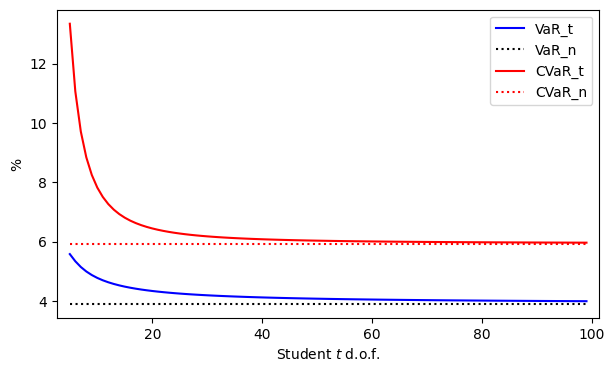

In [10]:
%matplotlib inline

d = []
for nu in range(5, 100):
    xanu = t.ppf(alpha, nu)
    CVaR_t = -1/alpha * (1-nu)**(-1) * (nu-2+xanu**2) * \
             t.pdf(xanu, nu)*sig_h - mu_h
    VaR_t = np.sqrt(h/252 * (nu-2)/nu) * t.ppf(1-alpha, nu)*sig \
             - mu_h
    d.append([nu, VaR_t, CVaR_t])
 
d = np.array(d).T
 
fig, ax = plt.subplots(figsize=(7,4))
plt.plot(d[0], d[1]*100, 'b-', label="VaR_t")
plt.plot(np.arange(5, 100), VaR_n*np.ones(95)*100, ":k", label="VaR_n")
plt.plot(d[0], d[2]*100, 'r-', label="CVaR_t")
plt.plot(np.arange(5, 100), CVaR_n*np.ones(95)*100, ":r",label="CVaR_n" )
plt.xlabel("Student $t$ d.o.f.")
plt.ylabel("%")
plt.legend(loc=1)
ax.margins(x=0.025, y=0.05) # add extra padding

### Computing ES for an actual set of returns ###

In [11]:
import quandl
import datetime
quandl.ApiConfig.api_key = ""

In [12]:
end = datetime.datetime.now()
start = end - datetime.timedelta(365*5)
AAPL = quandl.get('EOD/AAPL', start_date=start, end_date=end)

NotFoundError: (Status 404) (Quandl Error QECx02) You have submitted an incorrect Dataset code. Please check your Dataset codes and try again.

In [11]:
returns = (AAPL['Close']/AAPL['Close'].shift(1))-1
# Take the array from 2nd (element 1) to end and divide it by the array less the last element
# Basically tom - today for each element

In [12]:
returns = returns.dropna().values
returns

array([-0.00713669, -0.01242879,  0.02351337, ...,  0.00760178,
       -0.01077126,  0.01438023])

Fitting to a normal distribution

In [13]:
mu_norm, sig_norm = norm.fit(returns) # extract the mean and sigma of the closest normal distribution fit
print("Normal mean is {0:.8f}, sigma is {1:.8f}".format(mu_norm, sig_norm))
dx = 0.0001 # resolution of the distribution
x = np.arange(-1, 1, dx)
pdf_n = norm.pdf(x, mu_norm, sig_norm)

Normal mean is 0.00032809, sigma is 0.02798557


Fitting to a t-distribution

In [14]:
nu, mu_t, sig_t = t.fit(returns)
nu = np.round(nu)
print("Student T mean is {0:.8f}, sigma is {1:.8f}, nu is {2}".format(mu_t, sig_t, nu))
pdf_t = t.pdf(x, nu, mu_t, sig_t)

Student T mean is 0.00094189, sigma is 0.00959287, nu is 3.0


In [15]:
h = 1
alpha = 0.01
xanu = t.ppf(alpha, nu)

CVaR_n = alpha**-1 * norm.pdf(norm.ppf(alpha))*sig_norm - mu_norm
VaR_n = norm.ppf(1-alpha)*sig_norm - mu_norm
 
VaR_t = np.sqrt((nu-2)/nu) * t.ppf(1-alpha, nu)*sig_norm  - h*mu_norm
CVaR_t = -1/alpha * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu)*sig_norm  - h*mu_norm

In [16]:
print("The 99% VaR (Normal) is {0:.2f}%".format(VaR_n*100))
print("The 99% CVaR (Normal) is {0:.2f}%".format(CVaR_n*100))
print("The 99% VaR (Student-t) is {0:.2f}%".format(VaR_t*100))
print("The 99% CVaR (Student-t) is {0:.2f}%".format(CVaR_t*100))

The 99% VaR (Normal) is 6.48%
The 99% CVaR (Normal) is 7.43%
The 99% VaR (Student-t) is 7.30%
The 99% CVaR (Student-t) is 17.91%


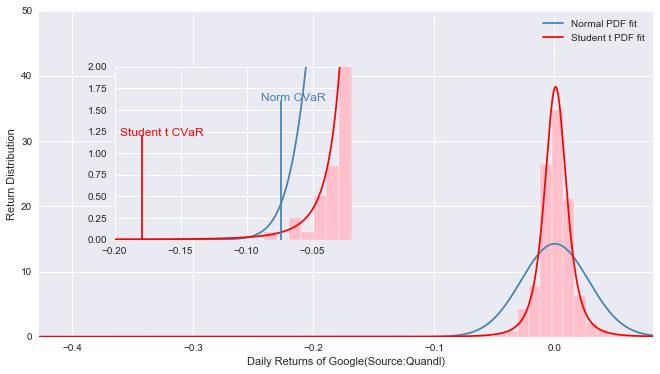

In [17]:
import seaborn as sns
plt.figure(num=1, figsize=(11, 6))
# main figure
plt.hist(returns, bins=100, normed=True, color='pink', edgecolor='white')
plt.hold(True)
plt.axis("tight")
plt.plot(x, pdf_n, 'steelblue', label="Normal PDF fit")
plt.hold(True)
plt.axis("tight")
plt.plot(x, pdf_t, 'red', label="Student t PDF fit")
plt.xlim([min(returns)/2, max(returns)])
plt.ylim([0, 50])
plt.legend(loc="best")
plt.xlabel("Daily Returns of Google(Source:Quandl)")
plt.ylabel("Return Distribution")
# inset
a = plt.axes([.22, .35, .3, .4])
plt.hist(returns, bins=100, normed=True, color='pink', edgecolor='white')
plt.hold(True)
plt.plot(x, pdf_n, 'steelblue')
plt.hold(True)
plt.plot(x, pdf_t, 'red')
plt.hold(True)
# Student VaR line
plt.plot([-CVaR_t, -CVaR_t], [0, 1.2], c='red')
# Normal VaR line
plt.plot([-CVaR_n, -CVaR_n], [0, 1.6], c='steelblue')
plt.text(-CVaR_n-0.015, 1.6, "Norm CVaR", color='steelblue')
plt.text(-CVaR_t-0.0171, 1.2, "Student t CVaR", color='red')
plt.xlim([-0.2, -0.02])
plt.ylim([0, 2])
plt.show()